<a href="https://colab.research.google.com/github/jyns417/Aiffel_quest_cr2/blob/master/MainQuest/Quest02/MainQuest02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MainQuest 02

1. 데이터 전처리
2. Decision Tree 으로 기본 모델 만들기
3. Feature Engineering
4. 비교모델 만들기
5. 모델별로 비교분석
6. 회고 및 Reference

## 1. 데이터 전처리


In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 데이터셋 가져오기
csv_path = "/content/Pokemon.csv"
original_data = pd.read_csv(csv_path)

# curation 할수잇도록 copy 만들기
pokemon = original_data.copy()
#legendary = pokemon[pokemon["Legendary"] == True].reset_index(drop=True)
#ordinary = pokemon[pokemon["Legendary"] == False].reset_index(drop=True)

types = list(set(pokemon["Type 1"]))

In [128]:
features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation'] #데이터 중에서 Name, Type1,2 는 유용하지 않으므로 feature 에서 제외
target = 'Legendary' #target 설정

# original data 에서 feature, target 을 column 으로 갖는 input X, target y
X=original_data[features]
y=original_data[target]

# train, test set 으로 나눠주기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=15)

#print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)

## 2. Decision Tree 으로 기본 모델 만들고 평가하기

In [129]:
from sklearn.tree import DecisionTreeClassifier

# model 만들기
model=DecisionTreeClassifier(random_state=25)

# model 에 training 시킨 후 test 값 얻기
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

In [130]:
from sklearn.metrics import confusion_matrix
cm0=confusion_matrix(y_test, y_pred)

In [131]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.98      0.97       147
        True       0.73      0.62      0.67        13

    accuracy                           0.95       160
   macro avg       0.85      0.80      0.82       160
weighted avg       0.95      0.95      0.95       160



### 기본 모델에 대한 분석
- accuracy: 95%
- 상식수준에서 확률적으로 나올 수 있는 수준: 92% (735//800) -> 생각보다 accuracy 가 높지 않다는 것을 알 수 있다. 그리고 찍어도 비슷한 accuracy 가 나오기 때문에 Recall 값으로 판단해야한다

- 이 경우에는 True 에 대한 Recall 값이 0.67 으로 낮은데, 이는 False Negative, 즉 전설의 포켓몬을 일반포켓몬이라고 생각하는 경우가 높음을 의미한다. -> Recall 값으로 비교하는 것이 타당함!

## 3. Feature enginering

#### 3.1 stats 에 대한 비교
- Stats: Attack, Sp. Atk, Speed stat 값이 total 과 거의 비례한다
- Total: 평균적으로 7개가 같은 값을 가지고 대략 600 ~ 700 사이

####3.2 Name 에 따른 비교
전설의 포켓몬은 이름의 길이가 10 이상인 경우 확률이 높고, 비슷한이름을 공유한다!

- name_counts: 이름의 length 정보를 추가
- long_name: name_counts가 10 이상인 경우 True 를 반환하는 coumn 을 추가

In [132]:
pokemon["name_count"]=pokemon["Name"].apply(lambda i:len(i))
pokemon["long_name"]=pokemon["name_count"]>=10
#pokemon.head()

- 전설의 포켓몬들의 이름에서 중복되는 token 은 65개이고, 가장 흔한 것들은 아래와 같다
- [('Forme', 15),
 ('Mega', 6),
 ('Mewtwo', 5),
 ('Kyurem', 5),
 ('Deoxys', 4),
 ('Hoopa', 4),
 ('Latias', 3),
 ('Latios', 3),
 ('Kyogre', 3),
 ('Groudon', 3)]


 - 이것들을 포함하는 지에 대한 여부를 feature 로 추가

In [133]:
# 이름에서 띄어쓰기 모두 없애주고
pokemon["Name_nospace"]=pokemon["Name"].apply(lambda i:i.replace(" ", ""))
# 알파벳외의 글자가 포함되어있는 경우도 모두 replace
pokemon = pokemon.replace(to_replace="Nidoran♀", value="Nidoran X")
pokemon = pokemon.replace(to_replace="Nidoran♂", value="Nidoran Y")
pokemon = pokemon.replace(to_replace="Farfetch'd", value="Farfetchd")
pokemon = pokemon.replace(to_replace="Mr. Mime", value="Mr Mime")
pokemon = pokemon.replace(to_replace="Porygon2", value="Porygon Two")
pokemon = pokemon.replace(to_replace="Ho-oh", value="Ho Oh")
pokemon = pokemon.replace(to_replace="Mime Jr.", value="Mime Jr")
pokemon = pokemon.replace(to_replace="Porygon-Z", value="Porygon Z")
pokemon = pokemon.replace(to_replace="Zygarde50% Forme", value="Zygarde Forme")

pokemon["name_isalpha"] = pokemon["Name_nospace"].apply(lambda i: i.isalpha())
# print(pokemon[pokemon["name_isalpha"]==False].shape) -> 모두 alphabet 으로 변겨된 것 확인함 (0,17)

# 이름을 토큰화시켜서 전설의포켓몬에서 자주 반복되는 토큰찾기
# 이름 토큰화 함수
import re
def tokenize(name):
  name_split=name.split(" ")
  tokens=[]
  for part_name in name_split:
    a=re.findall('[A-Z][a-z]*', part_name)
    tokens.extend(a)
  return np.array(tokens)

all_tokens=list(legendary["Name"].apply(tokenize).values)
token_set=[]
for token in all_tokens:
  token_set.extend(token)
print(len(set(token_set)))

from collections import Counter
most_common=Counter(token_set).most_common(10)  #가장 흔한 token 을 파악. Frome 가 가장 많음 !!

# 가장 흔한 10개의 token 이 포함된 이름인지를 F/T 으로 column 에 입력
for token, _ in most_common:
  pokemon[f"{token}"]=pokemon["Name"].str.contains(token)


65


####3.3 Type 에 대한 비교
전설의 포켓몬에는 일부 type 이 아예 포함되지 않는다.
- type 1, 2 에 따라 one-hot-encoding

In [134]:
# type 1 or 2 에 포함되는 type 별로 one-hot-encoding 시행
for t in types:
  pokemon[t]=(pokemon["Type 1"]==t)|(pokemon["Type 2"]==t)
# pokemon[[["Type 1", "Type 2"] + types][0]].head() -> one hot encoding 된 것 확인함

## 4. 비교 모델 만들기 및 평가하기

- 4.1 new features with DecisionTree
- 4.2 new features with RandomForest
- 4.3 new features with SVM
- 4.4 new feqtures with SGDClassifier
- 4.5 new features with LogisticRegression



#### 4.1 New feautures with DecisionTree




In [154]:
# original data 에서 전설의포켓몬이 가지고 있는 특성들을 잘 추출할수 있는 새로운 column 을 추가해서 features 를 다시 정의한다
new_features = ['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed', 'Generation',
            'name_count','long_name',
            'Forme', 'Mega', 'Mewtwo','Deoxys', 'Kyurem', 'Latias', 'Latios',
            'Kyogre', 'Groudon', 'Hoopa','Poison', 'Ground', 'Flying', 'Normal', 'Water', 'Fire',
            'Electric','Rock', 'Dark', 'Fairy', 'Steel', 'Ghost', 'Psychic', 'Ice', 'Bug', 'Grass', 'Dragon', 'Fighting']


In [155]:
# New features 를 input 으로 갖는 새로운 X 를 설정
X=pokemon[new_features]
y=pokemon[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=15)

#print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)

###### model1: new features with DecisionTree
model=DecisionTreeClassifier(random_state=25)

# model1 에 training 시킨 후 test 값 얻기
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

# 모델에 대해 평가하기
cm1=confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.96      0.98       147
        True       0.67      0.92      0.77        13

    accuracy                           0.96       160
   macro avg       0.83      0.94      0.87       160
weighted avg       0.97      0.96      0.96       160



#### 4.2 New feautures with RandomForest

In [156]:
###### model2: new features with RandomForest
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(random_state=25)

# model2 에 training 시킨 후 test 값 얻기
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

# 모델에 대해 평가하기
cm2=confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.97      0.98       147
        True       0.71      0.77      0.74        13

    accuracy                           0.96       160
   macro avg       0.85      0.87      0.86       160
weighted avg       0.96      0.96      0.96       160



#### 4.3 New feautures with SVM

In [157]:
###### model3: new features with SVM
from sklearn import svm
svm_model=svm.SVC()

# model3 에 training 시킨 후 test 값 얻기
svm_model.fit(X_train, y_train)
y_pred=svm_model.predict(X_test)

# 모델에 대해 평가하기
cm3=confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.99      0.97       147
        True       0.78      0.54      0.64        13

    accuracy                           0.95       160
   macro avg       0.87      0.76      0.80       160
weighted avg       0.95      0.95      0.95       160



#### 4.4 New feautures with SGDClassifier

In [158]:
###### model4: new features with SGDClassifier
from sklearn.linear_model import SGDClassifier
sgd_model=SGDClassifier()

# model3 에 training 시킨 후 test 값 얻기
sgd_model.fit(X_train, y_train)
y_pred=sgd_model.predict(X_test)

# 모델에 대해 평가하기
cm4=confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      0.92      0.92       147
        True       0.08      0.08      0.08        13

    accuracy                           0.85       160
   macro avg       0.50      0.50      0.50       160
weighted avg       0.85      0.85      0.85       160



#### 4.5 New feautures with LogisticRegression

In [159]:
###### model5: new features with LogisticRegression
from sklearn.linear_model import LogisticRegression
logistic_model=LogisticRegression()

# model3 에 training 시킨 후 test 값 얻기
logistic_model.fit(X_train, y_train)
y_pred=logistic_model.predict(X_test)

# 모델에 대해 평가하기
cm5=confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.95      1.00      0.98       147
        True       1.00      0.46      0.63        13

    accuracy                           0.96       160
   macro avg       0.98      0.73      0.80       160
weighted avg       0.96      0.96      0.95       160



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 5. 모델별로 비교분석

<Figure size 640x480 with 0 Axes>

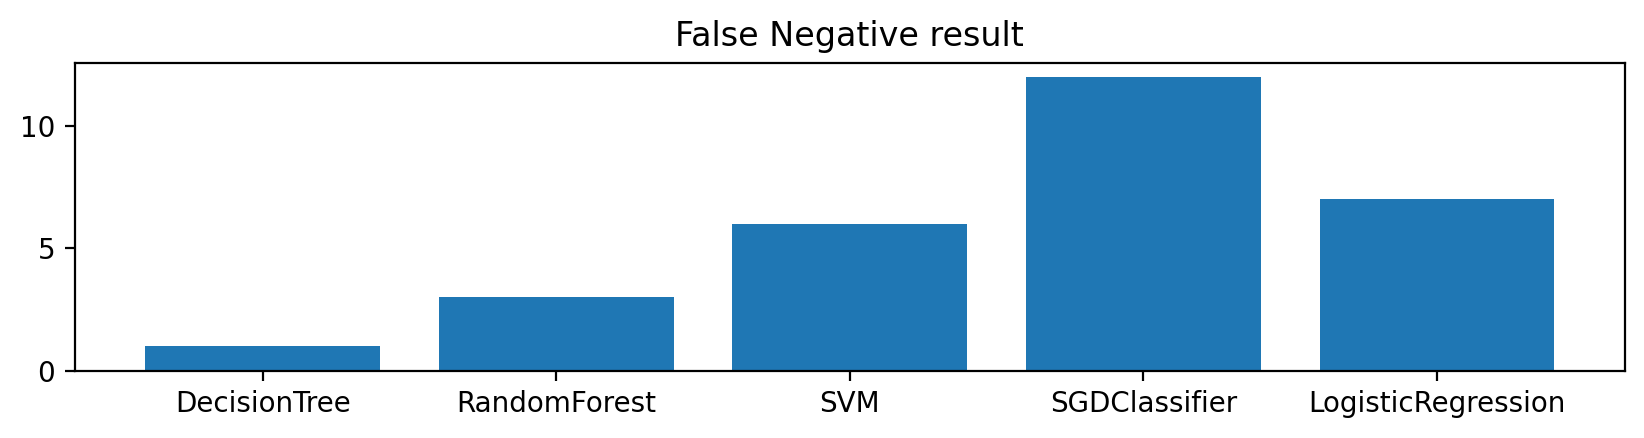

In [171]:
result_FN=(cm1[1][0], cm2[1][0], cm3[1][0], cm4[1][0], cm5[1][0])
#print(result_FN)
subjects=["DecisionTree", "RandomForest", "SVM", "SGDClassifier", "LogisticRegression"]

fig=plt.figure()
fig=plt.figure(figsize=(10,2))

ax1=fig.add_subplot(1,1,1)
ax1.bar(subjects, result_FN)
plt.title('False Negative result')

plt.show()

- 가장 FN 가 낮은 모델은 DecisionTree 임이 확인되었다. 비선형적인 관계를 예측하고 데이터의 노이즈가 별로 없었던 경우이므로 결과가 가장 좋게 나올 수 있었다.

- 이외로는, 레전드포켓몬을 구분하는 데에 있어서 Linear 관계를 탐색하는 모델인 SVM, SGD, Classifier 는 레전드 포켓몬이 feature 와 항상 linear 한 관계를 갖지 않는다는 점에서 결과가 나쁘게 나올 수 있다. feature 를 다른 것을 사용한다면 더 좋은 결과가 나올수도 있겠다.

##6. 회고 및 Reference

#### 회고
- 생각보다 데이터셋을 feature engineering 하는데에 오랜 시간이 걸리고, 데이터를 만지는 데에 조심하지 않으면 결과값이 완전히 달라질 수 있을 것 같다는 생각이 들었다.
- 모델을 비교할 때 모델에 대한 이해와 데이터의 분포나 특성에 대한 이해가 동반되어야 하기 때문에 무작정 코딩해서 결과값이 나오더라도 이것을 이해하는 것은 더어려운 것 가탇.
- 그래서 차라리 데이터를 더 자세히 훑어보는 것이 최종 평가로 모델을 설정하는 데에는 더 유리할 것 같다는 생각이 든다 !!

#### Reference
- https://velog.io/@gongsam/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EB%AA%A8%EB%8D%B8-%EB%B9%84%EA%B5%90-1-Decision-Tree%EC%99%80-RandomForest

- https://velog.io/@gongsam/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EB%AA%A8%EB%8D%B8-%EB%B9%84%EA%B5%90-2-SVM-SGD-Logistic-Regression

- https://m.blog.naver.com/hannaurora/222498671200